# Further data preparation in R

 ## Introduction
In this notebook, we will prepare data for analysis. 

Specifically, we will:

- Format the data
- Add a disease outcome using a combination of data sources
- Perform exclusions for accelerometer data quality, prior disease, and missing data
- Recode data where appropriate


## About this notebook

This notebook is written in R. 

Note that this notebook uses the following conventions:

- base R syntax (you might be more familiar with either 'tidyverse' or 'data.table' syntax)
- data frames containing UKB data will be called 'dat_X'
- output tables will be called 'tab_X' 
- date variables will be called 'date_X'
- indicator variables will be called 'ind_X'


## How to run this notebook
This notebook should be run in a *JupyterLab* session, with R as the kernel. It does *not* require a Spark cluster. See how to set it up [here](https://dnanexus.gitbook.io/uk-biobank-rap/working-on-the-research-analysis-platform/using-jupyterlab-on-the-research-analysis-platform).

If you prefer, you could use the code chunks from this session in an R script or RMarkdown notebook in RStudio.

## Set up the session

Load packages we'll use:

In [1]:
# First we need to install packages that aren't already present
pkgs <- c("data.table", "plyr") # packages we need
pkgs_inst <- pkgs[!{pkgs %in% rownames(installed.packages())}] # check which are not present 
install.packages(pkgs_inst, repos = "https://www.stats.bris.ac.uk/R/") # install

# Load packages
lapply(pkgs, library, character.only = TRUE) # using lapply just allows us to load several packages on one line - this could be replaced with several calls to library()

[[1]]
[1] "data.table" "stats"      "graphics"   "grDevices"  "utils"     
[6] "datasets"   "methods"    "base"      

[[2]]
[1] "plyr"       "data.table" "stats"      "graphics"   "grDevices" 
[6] "utils"      "datasets"   "methods"    "base"

We load data: 

In [2]:
# Note that in order to be able to load the data from these locations, you will need to start a new Jupyter Lab session relative to the previous notebook.
# Alternatively you could replace these locations with appropriate file locations from the current session's storage, or you could try remounting (see: 
# community.dnanexus.com/s/question/0D5t000003vAWYxCAO/it-seems-that-the-recently-dx-uploaded-files-does-not-show-up-on-mntproject-until-i-restart-the-whole-jupyter-lab-vm)
dat <- fread("/mnt/project/Accelerometry_RAP_Demo/participant_wacc_data.csv", data.table = FALSE) # fread is a function from the data.table package for fast reading of large data
dat_hes <- fread("/mnt/project/Accelerometry_RAP_Demo/hes_wacc_data.csv", data.table = FALSE)
dat_death <- fread("/mnt/project/Accelerometry_RAP_Demo/death_wacc_data.csv", data.table = FALSE)
dat_death_cause <- fread("/mnt/project/Accelerometry_RAP_Demo/death_cause_wacc_data.csv", data.table = FALSE)

## Basic R formatting

We start by keeping a subset of columns which we are likely to use: 

In [3]:
cols_dat <- c("eid", "sex", "year_birth", "month_birth", "ethnicity_raw",
              "ukb_assess_cent",  "date_baseline", "date_inst_1", "date_inst_2", "date_lost_followup",
              "tdi_raw", "age_education_raw", "qualif_raw", "alcohol_raw", "smoking_raw", "BMI_raw",
              "self_report_cvd_baseline", "self_report_cvd_inst_1", "self_report_cvd_inst_2", 
              "date_end_accel", "quality_good_wear_time", "Wear duration overall", 
              "quality_good_calibration", "clips_before_cal", "clips_after_cal", "total_reads", 
              "overall_activity", colnames(dat)[grepl("acceleration", colnames(dat))])
cols_dat_hes <- c("eid","dnx_hesin_id", "dnx_hesin_diag_id", 
                  "dateepiimp",  "ins_index", "arr_index", "level",
                  "diag_icd9", "diag_icd9_nb", "diag_icd10", "diag_icd10_nb")

dat <- dat[, cols_dat]
dat_hes <- dat_hes[, cols_dat_hes]

We inspect the data structure to check all columns are the types we expect:

In [4]:
for (data in list(dat, dat_hes, dat_death, dat_death_cause)){
    str(data, vec.len = 0) # vec.len = 0 avoids accidentally printing data
}

'data.frame':	103669 obs. of  125 variables:
 $ eid                                          : int  NULL ...
 $ sex                                          : chr   ...
 $ year_birth                                   : int  NULL ...
 $ month_birth                                  : chr   ...
 $ ethnicity_raw                                : chr   ...
 $ ukb_assess_cent                              : chr   ...
 $ date_baseline                                : IDate, format:  ...
 $ date_inst_1                                  : IDate, format:  ...
 $ date_inst_2                                  : IDate, format:  ...
 $ date_lost_followup                           : IDate, format:  ...
 $ tdi_raw                                      : num  NULL ...
 $ age_education_raw                            : chr   ...
 $ qualif_raw                                   : chr   ...
 $ alcohol_raw                                  : chr   ...
 $ smoking_raw                                  : chr   ...
 $ 

Mostly this looks sensible, but there are some things to address. For example, why is "age_education_raw" formatted as character? It turns out it's because there are some special values for [age completed full time education](https://biobank.ndph.ox.ac.uk/showcase/field.cgi?id=845), which need to be removed before it can be coerced to numeric. Let's reformat it appropriately.

In [5]:
dat$age_education_revalued_raw <- plyr::revalue(dat$age_education_raw, c("Do not know" =  NA, "Prefer not to answer" = NA, "Never went to school" = 0))
dat$age_education_numeric_raw <- as.numeric(dat$age_education_revalued_raw)

We also do some simple formatting of date columns:

In [6]:
# Tabular participant data
dat$date_lost_followup <- as.Date(dat$date_lost_followup, format = "%Y-%m-%d")
dat$date_end_accel <- as.Date(dat$date_end_accel, format = "%Y-%m-%d")
for (suffix in c("baseline", "inst_1", "inst_2")){
 dat[, paste0("date_", suffix)] <- as.Date(dat[, paste0("date_", suffix)], format = "%Y-%m-%d") 
}

# HES data
dat_hes$date_hes <- as.Date(dat_hes$dateepiimp, format = "%Y-%m-%d")

# Death data
dat_death$date_death <-
  as.Date(dat_death$date_of_death, format = "%Y-%m-%d")
# A very small number of participants have duplicate records in death data (e.g. perhaps from a second death certificate after post-mortem)
# In this dataset we keep just one record per participant: they should have the same date, and we will use the death_cause dataset for any 
# other records related to death. It also only affects a very small number of participants.
dat_death <-
  dat_death[dat_death$ins_index == 0, ]

We'll do more involved processing later on, but this just ensures we have a sensibly coded dataset to work with.

## Find the first occurrence in hospital record data

We start by adding a column to the participant data with the date of the first HES record for the disease of interest (cardiovascular disease). We will need this in order to: 

- exclude participants who already had a cardiovascular disease (CVD) diagnosis by the time they wore the accelerometer 
- add the date of incident disease for participants who had their first CVD diagnosis after wearing the accelerometer

We briefly introduced the HES data in the last notebook. A bit more detail on the structure of the data: 

- Disease codes in HES data mostly use [ICD-10 codes](https://icd.who.int/browse10/2010/en). Some records from the 1990s and earlier use its precursor, ICD-9.
- Recall that there can be multiple records per participant (which is why we will look to identify the earliest record).
- The HES dataset we have extracted from UK Biobank is *inpatient* episodes only. That means that it only includes hospital visits where the participant occupied a bed (not necessarily overnight). This means Emergency Department attendances and outpatient appointments which did not result in admission will not be present in the data. This is more of an issue for some conditions than others. 
- While operations and procedures codes are also available in HES data, we won't use them here.
- There are some papers looking at the features of different data sources for different health outcomes e.g. [this paper on stroke](https://n.neurology.org/content/95/6/e697). [This paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3264740/) discusses contexts in which different aspects of accurate classification are important.
- If you want to learn more about HES data in UK Biobank, see [this resource](https://biobank.ndph.ox.ac.uk/showcase/ukb/docs/HospitalEpisodeStatistics.pdf).

Following [Ramakrishnan et al. (2021)](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1003487), here we will define a HES record for 'cardiovascular disease' as an appearance of ICD-10 codes I20-I25 (ischaemic heart disease) or I60-I69 (cerebrovascular disease). We will also consider ICD-9 codes 410-414 (ischaemic heart disease) and 430-438 (cerebrovascular disease):

In [7]:
# The lists of ICD codes we will consider
icd10_codes <- "I2[0-5]|I6"
icd9_codes <- "^410|^411|^412|^413|^414|^430|^431|^432|^433|^434|^435|^436|^437|^438"

# Restrict the HES data frame to occurrences of these codes
dat_hes_rel <- dat_hes[grepl(icd10_codes, dat_hes$diag_icd10) | grepl(icd9_codes, dat_hes$diag_icd9), c("eid", "date_hes", "diag_icd10", "diag_icd9") ]

# Find first occurrence
dat_hes_first_cvd <- aggregate(dat_hes_rel$date_hes, list(dat_hes_rel$eid), min)
colnames(dat_hes_first_cvd) <- c("eid", "date_hes_first_cvd")

# Merge into many data frame (left join)
dat <- merge(dat, 
             dat_hes_first_cvd,
             by = "eid",
             all.x = TRUE,
             suffixes = c("", "dup") # This just means that if we accidentally run it twice we won't rename the columns
            )

We now add indicator variables for CVD and whether it was prevalent (before accelerometer wear) or incident (after accelerometer wear):

In [8]:
# Add indicators of any cvd, prevalent CVD and incident CVD
dat$ind_hes_cvd <- !is.na(dat$date_hes_first_cvd)
dat$ind_inc_hes_cvd <- dat$ind_hes_cvd & (dat$date_hes_first_cvd > dat$date_end_accel)
dat$ind_prev_hes_cvd <- dat$ind_hes_cvd & (dat$date_hes_first_cvd <= dat$date_end_accel)

Note that the 'baseline' relative to which prevalent/ incident is determined for our analysis is *not* the main study baseline: it is the time of accelerometer wear, which took place in 2013-2015 (i.e. several years after the initial assessment in 2006-2010).

Finally, we do a few sense checks: 

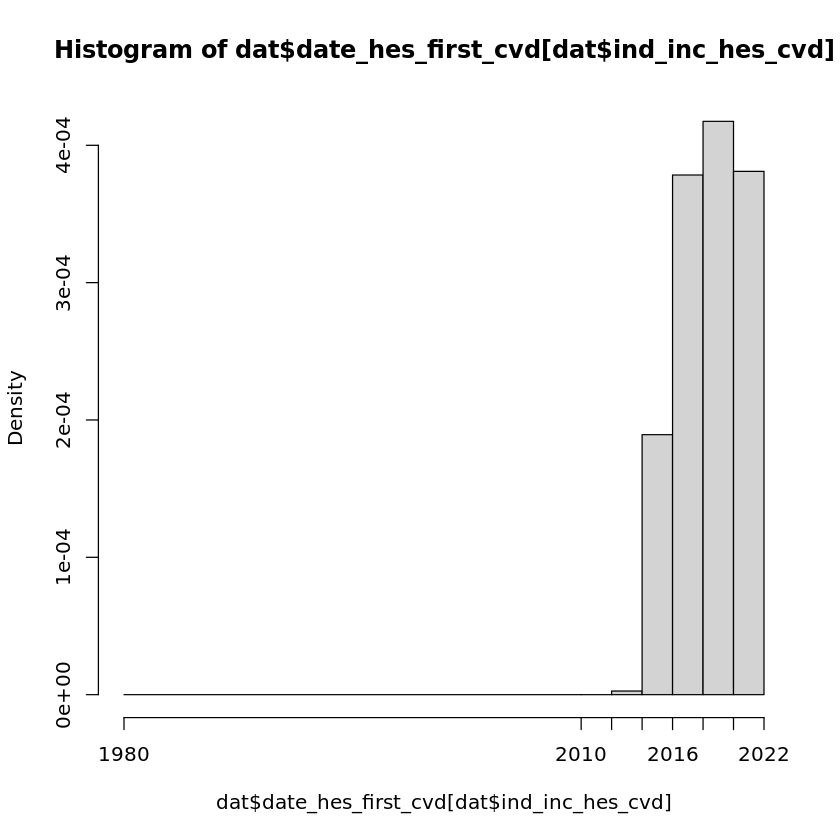

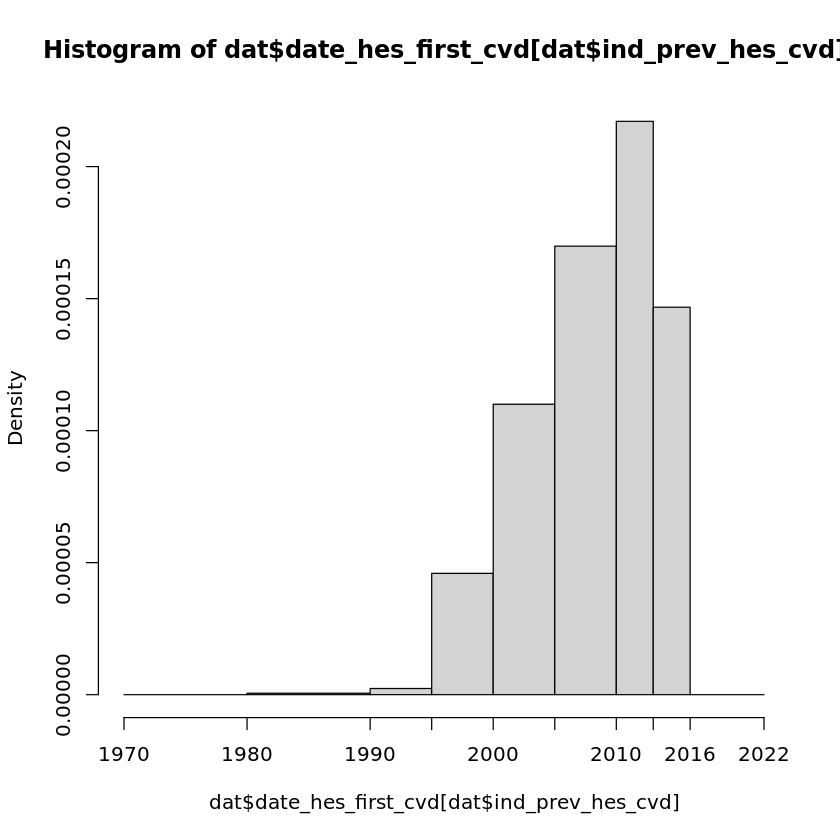

In [9]:
# Checks
hist(dat$date_hes_first_cvd[dat$ind_inc_hes_cvd], 
     breaks = as.Date(c("1980-01-01", "2010-01-01", "2012-01-01", "2014-01-01", "2016-01-01", "2018-01-01", "2020-01-01", "2022-01-01")))
hist(dat$date_hes_first_cvd[dat$ind_prev_hes_cvd], 
     breaks = as.Date(c("1970-01-01", "1980-01-01", "1990-01-01",  "1995-01-01", "2000-01-01", "2005-01-01", "2010-01-01", "2013-01-01", "2016-01-01", "2022-01-01")))

Recall our original note that, though we will not be inspecting the data directly in these notebooks, plenty of inspection was used in developing these notebooks and we encourage readers to add that throughout!

## Merge in death data

We will add an indicator variable indicating if the participant has died, and dates of death:

In [10]:
dat$ind_died <- dat$eid %in% dat_death$eid
dat <-
  merge(
    dat,
    dat_death[, c("eid", "date_death")],
    by = "eid",
    all.x = TRUE,
    suffixes = c("", "dup") # This makes it safe if we accidentally run it twice - we won't rename the columns
  )

## Exclusions

Before working with the data, we usually exclude some participants. Exclusions may be based on accelerometer data quality (e.g. the accelerometer was not worn for long enough), prevalent disease, and missing data in covariates.

We will record how many participants are excluded at each of the steps (e.g. for a flow diagram):

In [11]:
tab_exc <- data.frame("Exclusion" = "Starting cohort", "Number_excluded" = NA, "Number_remaining" = nrow(dat))

First, we exclude participants with poor quality accelerometer data. [A standard protocol in UK Biobank](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0169649) is to exclude participants whose data could not be calibrated, who had extreme values before or after calibration, who had insufficient wear time, or who had unrealistically high overall activity (acceleration) values. Each of these criteria could be defined in different ways. For example, what is an 'extreme' value? Here we will use the threshold of 100 m*g* (roughly indicating a level of activity equivalent to spending the whole day in moderate-to-vigorous physical activity), but this is clearly arbitrary. What is 'good' wear time? Here we will use the threshold of >3 days overall, to ensure a reasonable level of overall wear, and wear in each hour of the 24-hour day, to account for participants who did not wear the accelerometer throughout the day (meaning missing data could not be imputed in a way that would account for diurnal bias). See [this paper](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0169649) for evidence on this criterion. For different research questions, you may choose to select different criteria. For example, to study the difference between weekdays and weekend days would require wear time during both the week and the weekend. If you're interested in finding out more, check out the literature on accelerometer data quality! 

We do the accelerometer data quality exclusions:

- Exclude participants whose device could not be calibrated: 

In [12]:
nb <- nrow(dat)
dat <- dat[dat$quality_good_calibration == "Yes", ]
tab_exc <- rbind(tab_exc, data.frame("Exclusion" = "Poor calibration", "Number_excluded" = nb - nrow(dat), "Number_remaining" = nrow(dat)))

- Exclude participants for whom >1% of values were clipped (fell outside the sensor's range) before or after calibration: 

In [13]:
nb <- nrow(dat)
dat <- dat[(dat$clips_before_cal < 0.01*dat$total_reads) & (dat$clips_after_cal < 0.01*dat$total_reads) , ]
tab_exc <- rbind(tab_exc, data.frame("Exclusion" = "Too many clips", "Number_excluded" = nb - nrow(dat), "Number_remaining" = nrow(dat)))

- Exclude participants who had <3 days wear or did not have wear in each hour of the 24 hour day: 

In [14]:
nb <- nrow(dat)
dat <- dat[dat$quality_good_wear_time == "Yes", ] # Note that this has already been calculated in UKB, 
# we don't need to manually calculate it: https://biobank.ndph.ox.ac.uk/showcase/field.cgi?id=90015
tab_exc <- rbind(tab_exc, data.frame("Exclusion" = "Poor wear time", "Number_excluded" = nb - nrow(dat), "Number_remaining" = nrow(dat)))

- Exclude participants with unrealistically high overall activity values: 

In [15]:
nb <- nrow(dat)
dat <- dat[dat$overall_activity < 100, ]
tab_exc <- rbind(tab_exc, data.frame("Exclusion" = "Very high overall activity", "Number_excluded" = nb - nrow(dat), "Number_remaining" = nrow(dat)))

We will also exclude people who had already had a cardiovascular disease event at the time they wore the accelerometer. First we exclude people who had a CVD event meeting our definition in HES data before they wore the accelerometer:

In [16]:
nb <- nrow(dat)
dat <- dat[!(dat$ind_prev_hes_cvd), ]
tab_exc <- rbind(tab_exc, data.frame("Exclusion" = "Prevalent cardiovascular disease in HES", "Number_excluded" = nb - nrow(dat), "Number_remaining" = nrow(dat)))

We then exclude people who had no record in HES data before they wore the accelerometer, but had self-reported a CVD event meeting our definition before they wore the accelerometer (either at baseline or at the first or second repeat assessment, if this occurred before accelerometer wear):

In [17]:
nb <- nrow(dat)
dat$ind_prev_cvd_self_report_baseline <- grepl("Heart attack|Stroke|Angina", dat$self_report_cvd_baseline)
dat <- dat[!dat$ind_prev_cvd_self_report_baseline, ]
tab_exc <- rbind(tab_exc, data.frame("Exclusion" = "Prevalent self-reported CVD, baseline", "Number_excluded" = nb - nrow(dat), "Number_remaining" = nrow(dat)))

for (i in 1:2){
    nb <- nrow(dat)
    
    # Make condition
    dat[, paste0("ind_prev_cvd_self_report_inst_", i)] <- !is.na(dat[, paste0("date_inst_", i)]) &
                                            (dat[, paste0("date_inst_", i)] < dat$date_end_accel) & 
                                            (grepl("Heart attack|Stroke|Angina", dat[, paste0("self_report_cvd_inst_", i)]))
    
    # Do exclusion
    dat <- dat[!dat[, paste0("ind_prev_cvd_self_report_inst_", i)], ]
    
    # Record
    tab_exc <- rbind(tab_exc, data.frame("Exclusion" = paste0("Prevalent self-reported CVD, instance ", i), "Number_excluded" = nb - nrow(dat), "Number_remaining" = nrow(dat)))
}

Visualise exclusions so far:

In [18]:
tab_exc

Exclusion,Number_excluded,Number_remaining
<chr>,<int>,<int>
Starting cohort,NA,103669
Poor calibration,11,103658
Too many clips,0,103658
Poor wear time,6985,96673
Very high overall activity,13,96660
Prevalent cardiovascular disease in HES,5694,90966
"Prevalent self-reported CVD, baseline",1123,89843
"Prevalent self-reported CVD, instance 1",52,89791
"Prevalent self-reported CVD, instance 2",6,89785


Later we will also exclude some people with missing covariate data. 

## Variable preparation

We will start by adding an age-at-accelerometer-wear variable:

In [19]:
# Add date of birth
dat$approx_dob <-
  as.Date(paste(dat$year_birth, dat$month_birth, "15", sep = "-"),
          "%Y-%B-%d") # UK Biobank doesn't contain day of birth as it would be unnecessary identifying information, so we roughly impute it as the 15th of the birth month.
# Add age at entry in days
dat$age_entry_days <-
  difftime(dat$date_end_accel,
           dat$approx_dob,
           units = "days")

# Convert to age at entry in years
dat$age_entry_years <- as.double(dat$age_entry_days)/365.25

# Add age groups
dat$age_gp <-
  cut(
    dat$age_entry_years,
    breaks = c(40, 50, 60, 70, 80),
    right = FALSE,
    labels = c("40-49", "50-59", "60-69", "70-79")
  )


We will recode some variables for analytic purposes (e.g. collapsing multiple categories, coding missing values). As noted in the overall introduction, we follow [this paper](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1003487). These scripts illustrate *how* data can be processed and analysed, but should not be used as guidance on *what* decisions are made in a particular analysis: variable choice and coding is a decision on a case-by-case basis. 

In [20]:
# Ethnicity
dat$ethnicity <-
  plyr::revalue(
    dat$ethnicity_raw,
    c(
      "British" = "White",
      "Any other white background" = "White",
      "Irish" = "White",
      "White and Asian" = "Nonwhite",
      "Caribbean" = "Nonwhite",
      "Chinese"   = "Nonwhite",
      "Pakistani"  = "Nonwhite",
      "White and Black African" = "Nonwhite",
      "Other ethnic group"  = "Nonwhite",
      "Any other mixed background" = "Nonwhite",
      "African"    = "Nonwhite",
      "White and Black Caribbean" = "Nonwhite",
      "Prefer not to answer" = NA,
      "Indian"  = "Nonwhite",
      "White" = "White",
      "Do not know" = NA,
      "Any other Black background" = "Nonwhite",
      "Any other Asian background"  = "Nonwhite",
      "Bangladeshi"  = "Nonwhite",
      "Mixed"  = "Nonwhite",
      "Asian or Asian British"  = "Nonwhite",
      "Black or Black British"  = "Nonwhite"
    )
  )

# Townsend Deprivation Index
dat$tdi <- dat$tdi_raw

#  Education 
# people were not asked about the age at which they completed full time education if they reported a college or university degree
# we therefore impute as age 21 in this case
dat$age_education <- dat$age_education_numeric_raw 
dat$age_education[grepl("College or University degree", dat$qualif_raw)] <- 21
# check there are no values below 0, which shouldn't be possible:
print(nrow(dat[!is.na(dat$age_education) & dat$age_education < 0, ]))
# recode any values above 21 as 21 (for consistency with imputation):
dat$age_education[dat$age_education > 21] <- 21 

[1] 0


In [21]:
# Smoking
dat$smoking <-
  plyr::revalue(dat$smoking_raw, replace = c("Prefer not to answer" = NA))

# Alcohol
dat$alcohol <-
  plyr::revalue(
    dat$alcohol_raw,
    replace = c(
      "Prefer not to answer" = NA,
      "Three or four times a week" = "3+ times/week",
      "Special occasions only" = "<3 times/week",
      "One to three times a month" = "<3 times/week",
      "Daily or almost daily" = "3+ times/week",
      "Once or twice a week" = "<3 times/week"
    )
  )

# BMI
dat$BMI <- dat$BMI_raw

## Exclusions for missing data

We will do a complete case analysis. Therefore, we exclude people missing data in variables we will use for adjustment:

In [22]:
for (cov in c("age_entry_years", "sex", "ethnicity", "tdi", "age_education", "smoking", "alcohol", "BMI")){
  nb <- nrow(dat)
  missing_cov <- is.na(dat[, cov])|(as.character(dat[, cov]) == "") # for safety coerce to character for second check as can return NA on some classes e.g. Date
  dat <- dat[!missing_cov,]
  tab_exc <- rbind(
    tab_exc,
    data.frame(
      "Exclusion" = paste0("Missing ", cov),
      "Number_excluded" = nb - nrow(dat),
      "Number_remaining" = nrow(dat)
    )
  )
}
tab_exc

Exclusion,Number_excluded,Number_remaining
<chr>,<int>,<int>
Starting cohort,NA,103669
Poor calibration,11,103658
Too many clips,0,103658
Poor wear time,6985,96673
Very high overall activity,13,96660
Prevalent cardiovascular disease in HES,5694,90966
"Prevalent self-reported CVD, baseline",1123,89843
"Prevalent self-reported CVD, instance 1",52,89791
"Prevalent self-reported CVD, instance 2",6,89785


## Add 'final dataset' variables

Some variables can only be generated in the final analytic dataset (e.g. those based on quarters of the data).

We make a function to cut by quantile:

In [23]:
qtile_cut <-  function(x, probs = seq(0, 1, 0.25), na.rm = TRUE, labels = NULL) {
    breaks <- quantile(x = x, probs = probs, na.rm = na.rm)
    out <- cut(x = x, breaks = breaks, labels = labels, right = FALSE, include.lowest = TRUE)
    return(out)
  }

We cut overall activity and Townsend Deprivation Index into quarters:

In [24]:
dat$overall_activity_quarters <- qtile_cut(dat$overall_activity, labels = c("Quarter 1", "Quarter 2", "Quarter 3", "Quarter 4"))
dat$tdi_quarters <- qtile_cut(dat$tdi, labels = c("Quarter 1", "Quarter 2", "Quarter 3", "Quarter 4"))

## Add incident disease

We now add the outcome: time to incident cardiovascular disease. Participants can either:  

- be observed to have a cardiovascular disease diagnosis during their time in the study.
- be censored without having had a recorded cardiovascular disease diagnosis. [Censoring](https://www.publichealth.columbia.edu/research/population-health-methods/time-event-data-analysis#:~:text=This%20phenomenon%20is%20called%20censoring,participant%20experiences%20a%20different%20event) may occur at death, at the end of records, or at the date at which a particular participant was recorded to be lost-to-follow-up.

Loss-to-follow-up for particular participants is recorded in [field 191](https://biobank.ndph.ox.ac.uk/showcase/field.cgi?id=191). This currently hasn't been updated for several years.

[The censoring dates (the end of records) can be obtained from UK Biobank](https://biobank.ndph.ox.ac.uk/ukb/exinfo.cgi?src=Data_providers_and_dates). Note that procedures for how censoring dates are provided when data gets updated on the RAP are currently being established. In particular, there is currently a time gap between update of the Showcase data and update of the data provided on RAP. This mean that when the data is newly updated the censoring dates on the UK Biobank webpage may not apply to the RAP. Pending a solution to this (see [this question](https://community.dnanexus.com/s/question/0D5t000003rG3dgCAC/is-there-a-way-to-find-the-record-censoring-dates-for-a-particular-data-release-version) on the community forums), you may wish to manually check the censoring dates. For example, you can implement the rule described on the UK Biobank webpage: 

> *The censoring date is the last day of the month for which the number of records is greater than 90% of the mean of the number of records for the previous three months, except where the data for that month is known to be incomplete in which case the censoring date is the last day of the previous month.*

Records in different countries of the United Kingdom may have different censoring dates. We match participants to the appropriate censoring date based on the country in which they attended the baseline assessment centre. 

We record the relevant record censoring dates when we wrote this script (i.e. the end of records):

In [25]:
ind_wales <-
  dat$ukb_assess_cent %in% c("Cardiff", "Wrexham", "Swansea")
ind_scotland <- 
  dat$ukb_assess_cent %in% c("Edinburgh", "Glasgow")

# Note that if HES and death records have different censoring dates, we use the earlier one
dat$date_cens <- "2021-09-30"
dat$date_cens[ind_wales] <- "2016-03-31" # note we're using diagnosis data so we use diagnosis data censoring date
dat$date_cens[ind_scotland] <- "2021-07-31"
dat$date_cens <- as.Date(dat$date_cens)

Participants with a recorded loss-to-follow-up date should be censored at loss-to-follow-up:

In [26]:
# People who were lost to follow-up are censored at earliest of loss-to-follow-up and overall censoring
dat$date_cens <- pmin(dat$date_cens, dat$date_lost_followup, na.rm = TRUE)

# A few people are apparently lost to follow up in linked health records before they wore the accelerometer
# We exclude these people
nb <- nrow(dat)
dat <- dat[!(dat$date_cens < dat$date_end_accel), ]
tab_exc <- rbind(tab_exc, 
                 data.frame("Exclusion" = "Lost to linked health record follow-up before accelerometer study entry", "Number_excluded" = nb - nrow(dat), "Number_remaining" = nrow(dat)))
tab_exc

Exclusion,Number_excluded,Number_remaining
<chr>,<int>,<int>
Starting cohort,NA,103669
Poor calibration,11,103658
Too many clips,0,103658
Poor wear time,6985,96673
Very high overall activity,13,96660
Prevalent cardiovascular disease in HES,5694,90966
"Prevalent self-reported CVD, baseline",1123,89843
"Prevalent self-reported CVD, instance 1",52,89791
"Prevalent self-reported CVD, instance 2",6,89785



Participants who died should be censored at death, provided this occurred before the end of records: 

In [27]:
# People who died are censored at earliest of date of death and overall censoring
# e.g. a participant in Wales who died in 2020 should be censored at 28.02.2018
dat$date_cens[dat$ind_died] <-
  pmin(dat$date_cens[dat$ind_died], dat$date_death[dat$ind_died])

We now add a date for end of follow up, which is either the date at which the participant was censored or the date at which they experienced a CVD event in HES records as long as this occurred before censoring (occasionally, participants can have records occurring after the record censoring date):

In [28]:
# Add follow up variable
# i.e. same as censor date for participants without a hospital-recorded CVD diagnosis,
# event date for participants with hospital-recorded CVD diagnosis that falls within the study period
dat$date_fu <- dat$date_cens
dat$date_fu[dat$ind_inc_hes_cvd] <-
  pmin(dat$date_hes_first_cvd[dat$ind_inc_hes_cvd], dat$date_fu[dat$ind_inc_hes_cvd])

We now record the event status at exit. We don't use 'ind_inc_hes_cvd' directly as:  

- as noted above, there may be instances of people with an event in the data after censoring 
- more importantly, we will want to add people who have a record for CVD at death without a prior occurrence in HES data (e.g. someone who died suddenly of a stroke without being admitted to hospital)

In [29]:
dat$ind_inc_cvd <- FALSE

# Mark ind_inc_cvd for people with a HES-record of CVD during the study period
dat$ind_inc_cvd[dat$ind_inc_hes_cvd & (dat$date_hes_first_cvd == dat$date_fu)] <- TRUE

# Mark ind_inc_cvd for participants with a first record of CVD at death
ids_death_cvd <-
  dat_death_cause$eid[grepl("I2[0-5]|I6", dat_death_cause$cause_icd10)]
ind_death_cvd <-  dat$eid %in% ids_death_cvd
dat$ind_inc_cvd[ind_death_cvd &
                 (dat$date_fu == dat$date_death)] <- TRUE

We calculate follow up time (i.e. total time on study):

In [30]:
dat$fu_time <-
  as.double(difftime(dat$date_fu, dat$date_end_accel, units = "days"))

Alternatively, we might want to analyse the data using age as the timescale, so we add a variable for age at exit in days:

In [31]:
dat$age_exit_days <- as.double(dat$age_entry_days + dat$fu_time)
dat$age_exit_days2 <-  as.double(difftime(dat$date_fu, dat$approx_dob, units = "days")) # calculation in an alternative way just so we can implement a logic check

# Logic check
if (!isTRUE(all.equal(dat$age_exit_days, dat$age_exit_days2))){
    stop("Different methods of calculating age at exit give different answers")
}

We noted that it is well worth inspecting your data to check the code is behaving as expected, especially for some of the logically complex processes in this notebook. This isn't shown here, to minimise the risk of accidentally printing data on the internet, but here are just a few checks we can do to make sure things look sensible: 

Group.1,x
<chr>,<dbl>
Barts,7.0
Birmingham,7.0
Bristol,7.0
Bury,6.5
Cardiff,1.5
Croydon,7.0
Edinburgh,6.8
Glasgow,6.8
Hounslow,7.0


Group.1,x
<lgl>,<dbl>
FALSE,6.8
TRUE,4.0


Group.1,x
<lgl>,<dbl>
FALSE,6.8
TRUE,3.7


Group.1,x
<chr>,<date>
Barts,2021-09-30
Birmingham,2021-09-30
Bristol,2021-09-30
Bury,2021-09-30
Cardiff,2016-03-31
Croydon,2021-09-30
Edinburgh,2021-07-31
Glasgow,2021-07-31
Hounslow,2021-09-30


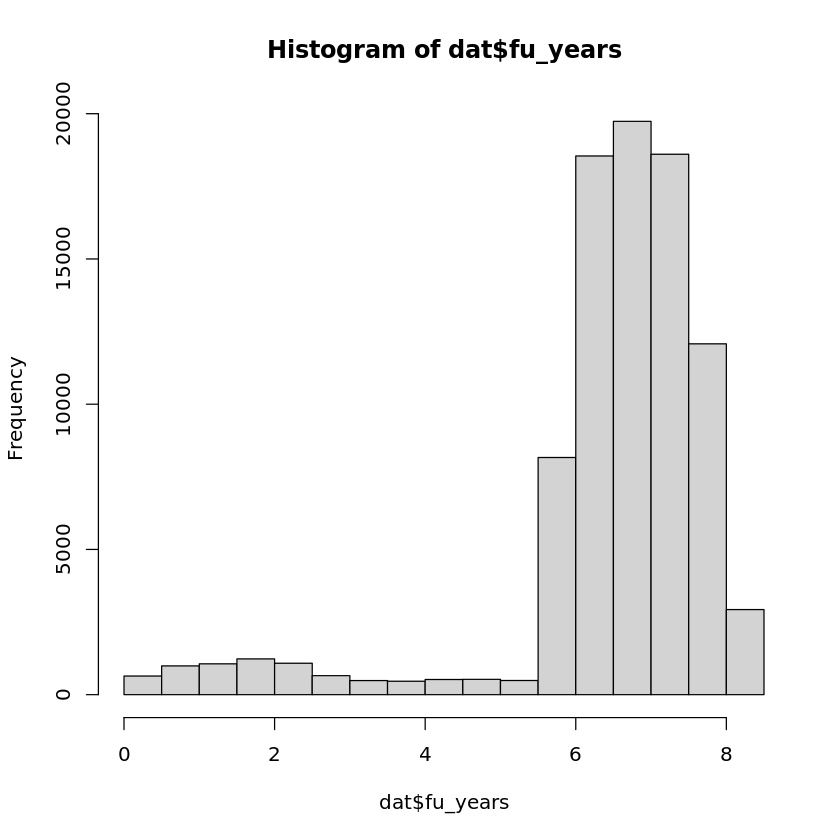

In [32]:
dat$fu_years <- dat$fu_time/365.25
# Follow up time distribution
hist(dat$fu_years)

# Follow up time in different groups
aggregate(dat$fu_years, list(dat$ukb_assess_cent), FUN = function(x) {round(median(x), digits = 1)}) 
aggregate(dat$fu_years, list(dat$ind_died), FUN = function(x) {round(median(x), digits = 1)}) 
aggregate(dat$fu_years, list(dat$ind_inc_cvd), FUN = function(x) {round(median(x), digits = 1)}) 

# Max follow up date by assessment centre
aggregate(dat$date_fu, list(dat$ukb_assess_cent), FUN = max)

## Writing out the data for reuse

As previously, we need to write out the data so we can reuse it, and upload it to the RAP system.


In [33]:
write.csv(dat, "prepped_data.csv", row.names = FALSE)

In [ ]:
# NB This won't run using an R kernel but can be run elsewhere - but we could open a terminal and run it there
%%bash
dx upload prepped_data.csv --dest Accelerometry_RAP_Demo/prepped_data.csv